# Prepare dataset

## Gdrive setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install torch torchvision torchsummary

In [1]:
import os

# project_root = '/content/drive/MyDrive/game_AI_project'
project_root = '/home/hp2427/mvst'
data_root = project_root + '/data'
vid_root = data_root + '/videos'
mask_root = data_root + '/masks'
annotations_file_train = data_root + '/annotations_train.txt'
annotations_file_val = data_root + '/annotations_val.txt'
annotations_file_test = data_root + '/annotations_test.txt'
# style_root = data_root + '/style'
style_root = '/scratch/hp2427' + '/style' #required for storing large number of files due to inode limits on home dir
style_class_dir = style_root + '/all'
checkpoints_root = project_root + '/checkpoints'
sample_output_root = '/scratch/hp2427' + '/sample_output'

# cur_dir = '/content'
cur_dir = '/home/hp2427/mvst'

for dir in [project_root, data_root, vid_root, mask_root, style_root, style_class_dir, checkpoints_root, sample_output_root]:
    try:
        os.mkdir(dir)
    except OSError as error:
        print(error)

[Errno 17] File exists: '/home/hp2427/mvst'
[Errno 17] File exists: '/home/hp2427/mvst/data'
[Errno 17] File exists: '/home/hp2427/mvst/data/videos'
[Errno 17] File exists: '/home/hp2427/mvst/data/masks'
[Errno 17] File exists: '/scratch/hp2427/style'
[Errno 17] File exists: '/scratch/hp2427/style/all'
[Errno 17] File exists: '/home/hp2427/mvst/checkpoints'
[Errno 17] File exists: '/scratch/hp2427/sample_output'


## get video_dataset.py

In [ ]:
!rm -rf Video-Dataset-Loading-Pytorch*

In [ ]:
!git clone https://github.com/RaivoKoot/Video-Dataset-Loading-Pytorch.git

In [ ]:
!cp Video-Dataset-Loading-Pytorch/video_dataset.py ./video_dataset.py

In [ ]:
!rm -rf Video-Dataset-Loading-Pytorch/

## Download and unzip DAVIS dataset [Not required if already present on mounted google drive]

In [ ]:
!git clone https://github.com/davisvideochallenge/davis-2017.git

In [ ]:
!davis-2017/data/get_davis.sh

In [ ]:
! rm -rf davis-2017/

### Copy data to Google drive, only if required

In [ ]:
#remove dirs where num frames do not match
import os
import os.path as path
# vid_path = '/content/DAVIS/JPEGImages/480p'
# mask_path = '/content/DAVIS/Annotations/480p'

vid_path = cur_dir + '/DAVIS/JPEGImages/480p'
mask_path = cur_dir + '/DAVIS/Annotations/480p'

annotations = []
for f in os.listdir(vid_path):
    if len(os.listdir(path.join(vid_path, f))) != len(os.listdir(path.join(mask_path, f))) or len(os.listdir(path.join(mask_path, f))) == 0:
        print('removing ', f)
        for g in os.listdir(path.join(vid_path, f)):
            os.remove(path.join(vid_path, f, g))
        for g in os.listdir(path.join(mask_path, f)):
            os.remove(path.join(mask_path, f, g))
        os.rmdir(path.join(vid_path, f))
        os.rmdir(path.join(mask_path, f))
    else:
        # print(f)
        min_frame = min(os.listdir(path.join(vid_path, f)))[:-4]
        max_frame = max(os.listdir(path.join(vid_path, f)))[:-4]
        annotations.append((f, min_frame, max_frame, 0))
print(annotations)

In [ ]:
train_count = 60
val_count = 15
test_count = 15

with open(cur_dir + '/annotations_train.txt', 'w') as f:
    for ann in annotations[:train_count]:
        f.write(f'{ann[0]} {int(ann[1])} {int(ann[2])} {ann[3]}\n')

with open(cur_dir + '/annotations_val.txt', 'w') as f:
    for ann in annotations[train_count:train_count+val_count]:
        f.write(f'{ann[0]} {int(ann[1])} {int(ann[2])} {ann[3]}\n')

with open(cur_dir + '/annotations_test.txt', 'w') as f:
    for ann in annotations[train_count+val_count:]:
        f.write(f'{ann[0]} {int(ann[1])} {int(ann[2])} {ann[3]}\n')

In [ ]:
## !rm -rf /content/drive/MyDrive/game_AI_project/data/videos/*
## !rm -rf /content/drive/MyDrive/game_AI_project/data/masks/*
# !mv /content/annotations_train.txt /content/drive/MyDrive/game_AI_project/data/annotations_train.txt
# !mv /content/annotations_val.txt /content/drive/MyDrive/game_AI_project/data/annotations_val.txt
# !mv /content/annotations_test.txt /content/drive/MyDrive/game_AI_project/data/annotations_test.txt
# !mv /content/DAVIS/JPEGImages/480p/* /content/drive/MyDrive/game_AI_project/data/videos/
# !mv /content/DAVIS/Annotations/480p/* /content/drive/MyDrive/game_AI_project/data/masks/

!mv /home/hp2427/mvst/annotations_train.txt /home/hp2427/mvst/data/annotations_train.txt
!mv /home/hp2427/mvst/annotations_val.txt /home/hp2427/mvst/data/annotations_val.txt
!mv /home/hp2427/mvst/annotations_test.txt /home/hp2427/mvst/data/annotations_test.txt
!mv /home/hp2427/mvst/DAVIS/JPEGImages/480p/* /home/hp2427/mvst/data/videos/
!mv /home/hp2427/mvst/DAVIS/Annotations/480p/* /home/hp2427/mvst/data/masks/
!rm -rf /home/hp2427/mvst/DAVIS/

## Visualize video data samples

In [2]:
from video_dataset import  VideoFrameDataset, ImglistToTensor
from torchvision import transforms
import torch
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os


def plot_video(rows, cols, frame_list, plot_width, plot_height, title: str):
    fig = plt.figure(figsize=(plot_width, plot_height))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     )

    for index, (ax, im) in enumerate(zip(grid, frame_list)):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_title(index)
    plt.suptitle(title)
    plt.show()


def denormalize(video_tensor):
        """
        Undoes mean/standard deviation normalization, zero to one scaling,
        and channel rearrangement for a batch of images.
        args:
            video_tensor: a (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        """
        inverse_normalize = transforms.Normalize(
            mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
            std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
        )
        return (inverse_normalize(video_tensor) * 255.).type(torch.uint8).permute(0, 2, 3, 1).numpy()


def video_dataset_demo():
    """
    This demo uses the dummy dataset inside of the folder "demo_dataset".
    It is structured just like a real dataset would need to be structured.

    TABLE OF CODE CONTENTS:
    1. Minimal demo without image transforms
    2. Minimal demo without sparse temporal sampling for single continuous frame clips, without image transforms
    3. Demo with image transforms
    4. Demo 3 continued with PyTorch dataloader
    5. Demo of using a dataset where samples have multiple separate class labels

    """
    # videos_root = os.path.join('/content', 'DAVIS/JPEGImages/480p')
    # masks_root = os.path.join('/content', 'DAVIS/Annotations/480p')
    # annotation_file = os.path.join('/content', 'annotations.txt')
    videos_root = vid_root
    masks_root = mask_root
    annotation_file = annotations_file_train

    preprocess = transforms.Compose([
        ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        transforms.Resize(256),  # image batch, resize smaller edge to 299
        transforms.CenterCrop(256),  # image batch, center crop to square 299x299
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    preprocess_mask = transforms.Compose([
        ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        torchvision.transforms.Grayscale(num_output_channels=3),
        torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),
        transforms.Resize(256),  # image batch, resize smaller edge to 299
        transforms.CenterCrop(256),  # image batch, center crop to square 299x299
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


    """ DEMO 1 WITHOUT IMAGE TRANSFORMS """
    dataset = VideoFrameDataset(
        root_path=videos_root,
        annotationfile_path=annotation_file,
        num_segments=10,
        frames_per_segment=1,
        imagefile_template='{:05d}.jpg',
        transform=preprocess,
        test_mode=True
    )

    sample = dataset[10]
    frames = sample[0]  # list of PIL images
    label = sample[1]   # integer label

    plot_video(rows=1, cols=5, frame_list=denormalize(frames), plot_width=15., plot_height=3.,
               title='Evenly Sampled Frames')

    mask_dataset = VideoFrameDataset(
        root_path=masks_root,
        annotationfile_path=annotation_file,
        num_segments=10,
        frames_per_segment=1,
        imagefile_template='{:05d}.png',
        transform=preprocess_mask,
        test_mode=True
    )

    mask_sample = mask_dataset[10]
    mask_frames = mask_sample[0]  # list of PIL images
    mask_label = mask_sample[1]   # integer label

    plot_video(rows=1, cols=5, frame_list=(mask_frames * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
               title='Evenly Sampled Frames')
    print('Dataset size : ', len(dataset))


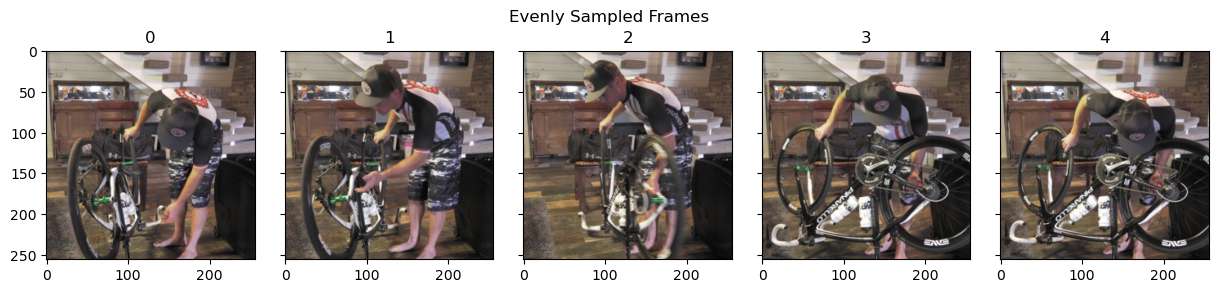

/state/partition1/job-46226980/ipykernel_4136130/1990740627.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),


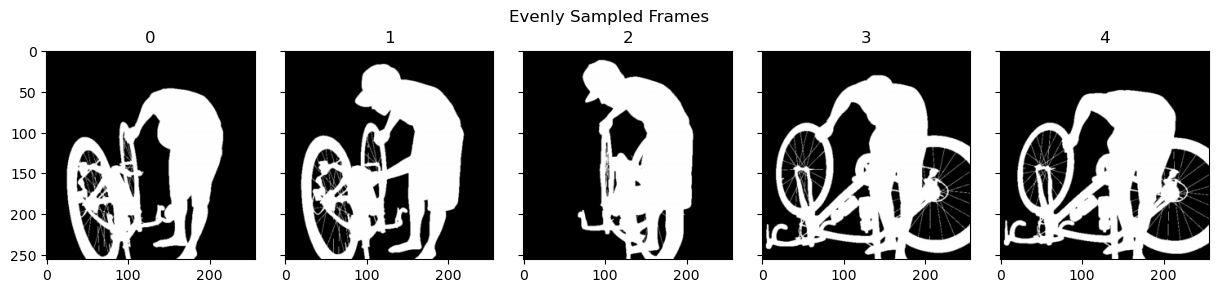

Dataset size :  60


In [3]:
video_dataset_demo()

## Download and unzip style dataset [Not required if already present on mounted google drive]

In [ ]:
!git clone https://github.com/himanshu1196/game-ai-style-transfer.git

In [ ]:
# !mv game-ai-style-transfer/data/style_random100.zip /content/drive/MyDrive/game_AI_project/data/style/all/random100.zip
# !unzip /content/drive/MyDrive/game_AI_project/data/style/all/random100.zip -d /content/drive/MyDrive/game_AI_project/data/style/all/
# !rm /content/drive/MyDrive/game_AI_project/data/style/all/random100.zip
# !mv /content/drive/MyDrive/game_AI_project/data/style/all/style_random100/* /content/drive/MyDrive/game_AI_project/data/style/all/
# !rm -rf /content/drive/MyDrive/game_AI_project/data/style/all/style_random100/

# !mv game-ai-style-transfer/data/style_random100.zip /home/hp2427/mvst/data/style/all/random100.zip
# !unzip /home/hp2427/mvst/data/style/all/random100.zip -d /home/hp2427/mvst/data/style/all/
# !rm /home/hp2427/mvst/data/style/all/random100.zip
# !mv /home/hp2427/mvst/data/style/all/style_random100/* /home/hp2427/mvst/data/style/all/
# !rm -rf /home/hp2427/mvst/data/style/all/style_random100/

### after uploading resized.zip to .../data/style/ dir
# !unzip /home/hp2427/mvst/data/style/resized.zip -d /scratch/hp2427/style/all/
# !rm -rf /scratch/hp2427/style/all/__MACOSX/
# !mv /scratch/hp2427/style/all/resized/* /scratch/hp2427/style/all/
# !rm -rf /scratch/hp2427/style/all/resized/

## Visualize style dataset

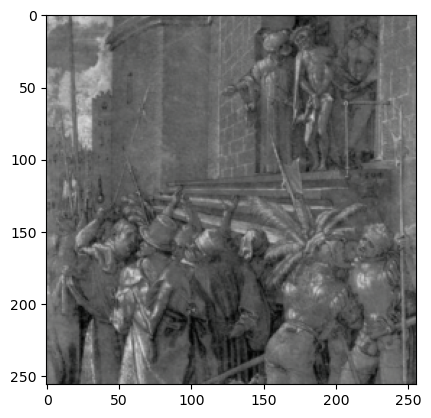

In [4]:
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

style_dataset = torchvision.datasets.ImageFolder(style_root, transforms.Compose([
    transforms.Resize(256),  # image batch, resize smaller edge to 299
    transforms.CenterCrop(256),  # image batch, center crop to square 299x299
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))

rnd_idx = np.random.randint(100)
plt.imshow(denormalize(style_dataset[rnd_idx][0].unsqueeze(0))[0])

## Define MVST Dataset

In [5]:
import os
from PIL import Image
import torch.nn.functional as F

import numpy as np
import torch
import torchvision
from torchvision import transforms
from torchvision.io import read_video
from torch.utils.data import Dataset
import random
from video_dataset import  VideoFrameDataset, ImglistToTensor

def resize(image, size):
    image = F.interpolate(image.unsqueeze(0), size=size, mode="nearest").squeeze(0)
    return image

def denormalize(video_tensor):
    """
    Undoes mean/standard deviation normalization, zero to one scaling,
    and channel rearrangement for a batch of images.
    args:
        video_tensor: a (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
    """
    inverse_normalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    return (inverse_normalize(video_tensor) * 255.).type(torch.uint8).permute(0, 2, 3, 1).numpy()


class MVSTDataset(Dataset):
    def __init__(self,cont_vids_path, cont_mask_vids_path, annotations_path, style_imgs_path, num_classes, img_size=256):

        self.preprocess = transforms.Compose([
            ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
            transforms.Resize(256),  # image batch, resize smaller edge to 299
            transforms.CenterCrop(256),  # image batch, center crop to square 299x299
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.preprocess_mask = transforms.Compose([
            ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
            torchvision.transforms.Grayscale(num_output_channels=1),
            torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),
            transforms.Resize(256),  # image batch, resize smaller edge to 299
            transforms.CenterCrop(256),  # image batch, center crop to square 299x299
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.cont_vids_path = cont_vids_path
        self.cont_mask_vids_path = cont_mask_vids_path
        self.annotation_file = annotations_path
        self.style_imgs_path = style_imgs_path
        self.style_img_files = self.list_files(style_imgs_path)
        self.img_size = img_size
        assert(num_classes == 2)
        self.num_classes = num_classes
        self.transform = transforms.Compose([
            transforms.Resize((self.img_size,self.img_size), Image.BICUBIC),
            transforms.ToTensor()
        ])
        self.FRAME_COUNT = 100
        self.dataset = VideoFrameDataset(
            root_path=cont_vids_path,
            annotationfile_path=annotations_path,
            num_segments=10,
            frames_per_segment=1,
            imagefile_template='{:05d}.jpg',
            transform=self.preprocess,
            test_mode=True
        )

        self.mask_dataset = VideoFrameDataset(
            root_path=cont_mask_vids_path,
            annotationfile_path=annotations_path,
            num_segments=10,
            frames_per_segment=1,
            imagefile_template='{:05d}.png',
            transform=self.preprocess_mask,
            test_mode=True
        )

        self.style_dataset = torchvision.datasets.ImageFolder(self.style_imgs_path, transforms.Compose([
            transforms.Resize(256),  # image batch, resize smaller edge to 299
            transforms.CenterCrop(256),  # image batch, center crop to square 299x299
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self,idx):
        # two random style images
        style_idx1 = np.random.randint(len(self.style_dataset))
        style_idx2 = np.random.randint(len(self.style_dataset))
        while style_idx2 == style_idx1:
            style_idx2 = np.random.randint(len(self.style_dataset))

        cont_idx = idx

        cont_vid_item = self.dataset.__getitem__(cont_idx)[0]
        cont_mask_vid_item = self.mask_dataset.__getitem__(cont_idx)[0]
        style_img_item1 = self.style_dataset.__getitem__(style_idx1)[0]
        style_img_item2 = self.style_dataset.__getitem__(style_idx2)[0]

        cont_mask_vid_item = torch.unsqueeze(cont_mask_vid_item, 0) # 1xFx3x256x256

        style_img_item1 = torch.unsqueeze(style_img_item1, 0) # 1x3x256x256
        style_img_item2 = torch.unsqueeze(style_img_item2, 0) # 1x3x256x256
        # print(f'loading : {cont_mask_vid_item.min()} {cont_mask_vid_item.max()} {(1-cont_mask_vid_item).min()} {(1-cont_mask_vid_item).max()}')
        return cont_vid_item, torch.cat([cont_mask_vid_item, 1-cont_mask_vid_item], dim=0), torch.cat([style_img_item1, style_img_item2], dim=0)


    def list_files(self, in_path):
        files = []
        for (dirpath, dirnames, filenames) in os.walk(in_path):
            files.extend(filenames)
            break
        files = sorted([os.path.join(in_path, x) for x in files])
        return files


### Visualize MVSTDataset

Using device: cuda


/state/partition1/job-46226980/ipykernel_4136130/3321574112.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),


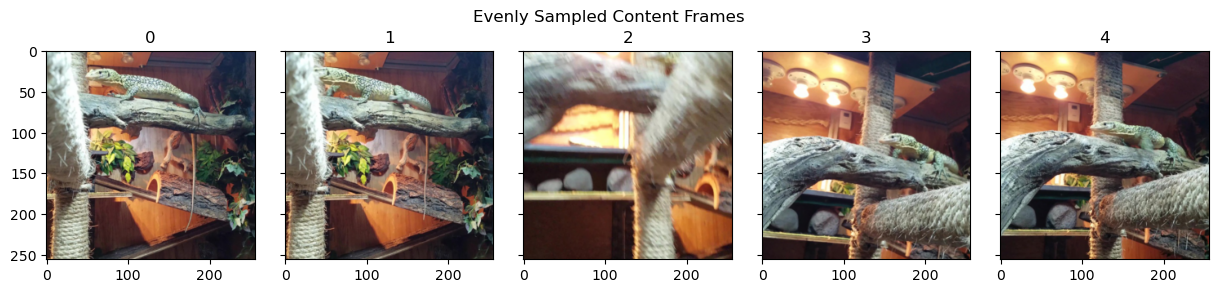

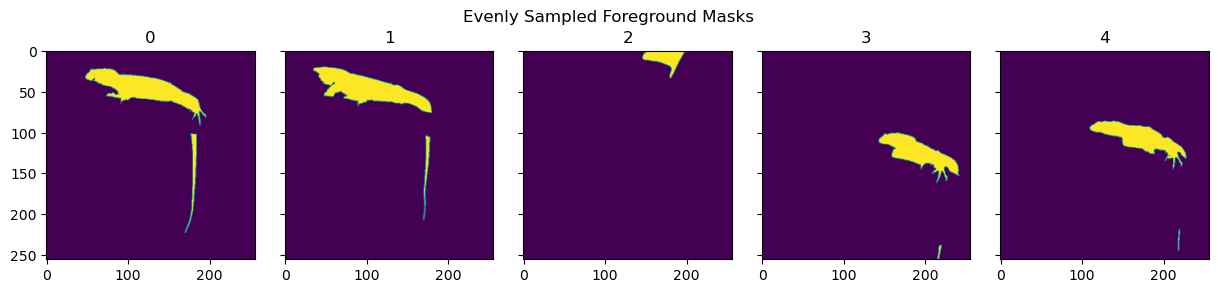

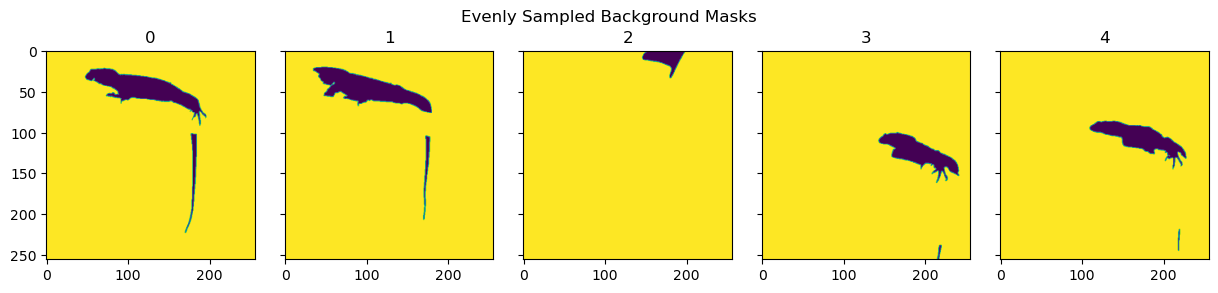

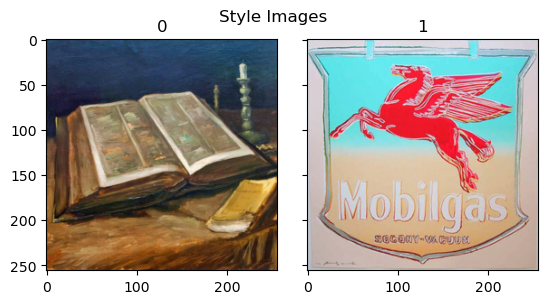

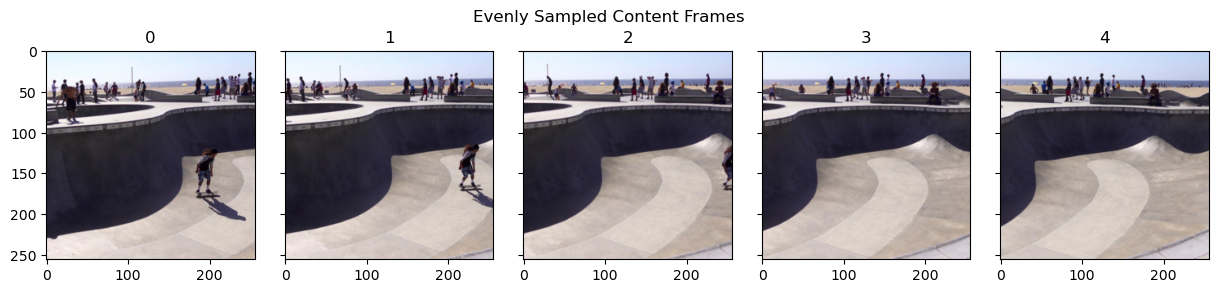

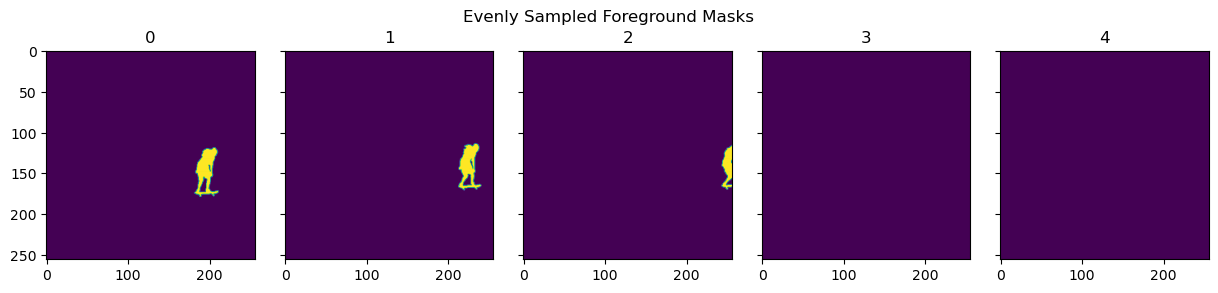

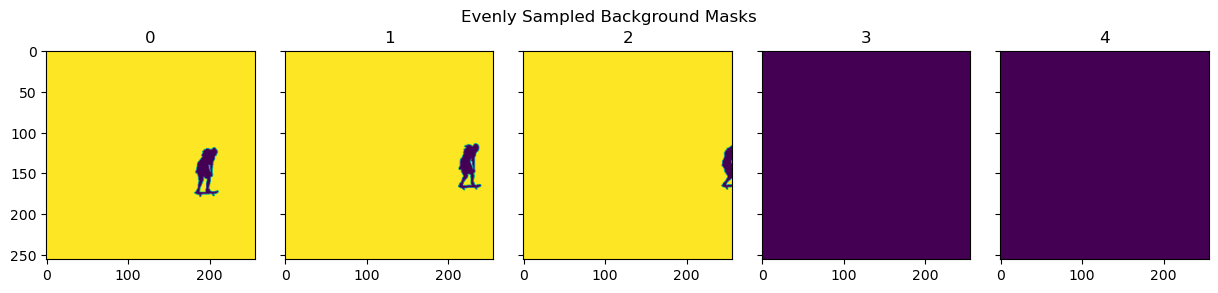

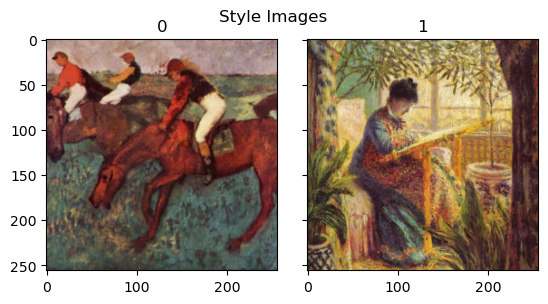

In [6]:
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
from torchvision.models.optical_flow import raft_small
from torchvision.models.optical_flow import Raft_Small_Weights
import sys

args = {}
args['cont_vids_path'] = vid_root #/vids
args['cont_mask_vids_path'] = mask_root #/mask_vids
args['annotations_path'] = annotations_file_val #/mask_vids
args['style_imgs_path'] = style_root #/style_images
args['num_classes'] = 2
args['batch_size'] = 4
args['checkpoint_path'] = checkpoints_root
args['output_path'] = sample_output_root
args['log_interval'] = 1
args['ckpt_interval'] = 2

cont_vids_path = args['cont_vids_path'] #/vids
cont_mask_vids_path = args['cont_mask_vids_path'] #/mask_vids
annotations_path = args['annotations_path'] #/annotations_path
style_imgs_path = args['style_imgs_path'] #/style_images
num_classes = args['num_classes'] #/num_classes
batch_size = args['batch_size']
checkpoint_path = args['checkpoint_path']
output_path = args['output_path']
log_interval = args['log_interval']
ckpt_interval = args['ckpt_interval']

# set dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
val_dataset = MVSTDataset(cont_vids_path, cont_mask_vids_path, annotations_path, style_imgs_path, num_classes, img_size=256)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

count = 0
for i ,(cont_imgs, mask_img_lists, style_img_lists) in enumerate(val_loader):
    #cont_img is B x num_frames x 3 x 256 x 256
    plot_video(rows=1, cols=5, frame_list=denormalize(cont_imgs[0]), plot_width=15., plot_height=3.,
               title='Evenly Sampled Content Frames')
    plot_video(rows=1, cols=5, frame_list=(mask_img_lists[0][0] * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
               title='Evenly Sampled Foreground Masks')
    plot_video(rows=1, cols=5, frame_list=(mask_img_lists[0][1] * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
               title='Evenly Sampled Background Masks')
    plot_video(rows=1, cols=2, frame_list=denormalize(style_img_lists[0]), plot_width=15., plot_height=3.,
               title='Style Images')
    count += 1
    if count >1:
        break

# Masked Video Style Transfer Model

### Define model

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time

import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torchvision import models
from torchsummary import summary
from torchvision.models.feature_extraction import create_feature_extractor

In [8]:
# model architecture

def resize(image, size):
    image = F.interpolate(image.unsqueeze(0), size=size, mode="nearest").squeeze(0)
    return image

def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def calc_mean_std_with_mask(x, mask, eps = 1e-5, eps_mean = 1e-3):
    """
    x of shape: [batch_size (N), features(C), num_objects (L)]
    mask of shape: [batch_size (N), num_objects (L)]
    """
    N, C = x.shape[0], x.shape[1]
    mask = mask.float().unsqueeze(1)  # (N,1,L)
    mean = (torch.sum(x * mask, 2) / (torch.sum(mask, 2) + eps_mean))   # (N,C)
    mean = mean.detach()
    var_term = ((x - mean.unsqueeze(2).expand_as(x)) * mask)**2  # (N,C,L)
    var = (torch.sum(var_term, 2) / (torch.sum(mask, 2) + eps))  #(N,C)
    var = var.detach()
    mean_reshaped = mean.view(N,C,1,1)  # (N, C, 1, 1)
    var_reshaped = var.view(N,C,1,1)    # (N, C, 1, 1)
    if mean_reshaped.isnan().any() or var_reshaped.isnan().any():
        print('...', mean_reshaped.isnan().any(), var_reshaped.isnan().any(), torch.sum(mask, 2))
    return mean_reshaped, var_reshaped ** 0.5

def ada_in(style_features, content_cur_masked_features, eps = 1e-5):
    # print('#', style_features.shape, content_cur_masked_features.shape, content_prev_masked_features.shape) #BxCxSxS

    x_cur_mean, x_cur_std = calc_mean_std(content_cur_masked_features)
    x_cur_std += eps

    style_mean, style_std = calc_mean_std(style_features)

    result = style_std * (content_cur_masked_features - x_cur_mean) / x_cur_std + style_mean
    return result

def ada_in_with_mask(style_features, content_cur_features, mask_cur):
    # print('#', style_features.shape, content_cur_masked_features.shape, content_prev_masked_features.shape) #BxCxSxS
    assert(len(content_cur_features.shape) == 4)
    B = content_cur_features.shape[0]
    C, H, W = content_cur_features.shape[-3], content_cur_features.shape[-2], content_cur_features.shape[-1]

    content_view = content_cur_features.view(B,C,-1)
    styleView = style_features.view(B,C,-1)

    mask_cur_resized = torchvision.transforms.Resize(size=(H,W), interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT)(mask_cur) #B x 1 x H x W
    mask_cur_resized_view = torch.reshape(mask_cur_resized, shape = (B,H*W)) # (N,1,L)

    x_cur_mean, x_cur_std = calc_mean_std_with_mask(content_view, mask_cur_resized_view)

    style_mean, style_std = calc_mean_std(style_features)

    result = style_std * (content_cur_features - x_cur_mean) / x_cur_std + style_mean
    return result * mask_cur_resized #zero out volume outside the mask

def st_ada_in(style_features, content_cur_features, content_prev_features, mask_cur, mask_prev, alpha = 0.1, eps = 1e-3):
    #use mask 1s as index into content features
    # print('#', style_features.shape, content_cur_masked_features.shape, content_prev_masked_features.shape) #BxCxSxS B x 512 x 32 x32
    assert(len(content_cur_features.shape) == 4)
    B = content_cur_features.shape[0]
    C, H, W = content_cur_features.shape[-3], content_cur_features.shape[-2], content_cur_features.shape[-1]

    content_view = content_cur_features.view(B,C,-1)
    content_prev_view = content_prev_features.view(B,C,-1)
    styleView = style_features.view(B,C,-1)

    mask_cur_resized = torchvision.transforms.Resize(size=(H,W), interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT)(mask_cur) #B x 1 x H x W
    mask_cur_resized_view = torch.reshape(mask_cur_resized, shape = (B,H*W))

    mask_prev_resized = torchvision.transforms.Resize(size=(H,W), interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT)(mask_prev) #B x 1 x H x W
    mask_prev_resized_view = torch.reshape(mask_prev_resized, shape = (B,H*W))

    x_cur_mean, x_cur_std = calc_mean_std_with_mask(content_view, mask_cur_resized_view)
    x_prev_mean, x_prev_std = calc_mean_std_with_mask(content_prev_view, mask_prev_resized_view)

    # print('#', type(alpha), type(x_cur_mean), type(x_prev_mean))
    combined_mean = (1-alpha) * x_cur_mean + alpha * x_prev_mean #BxCxL
    combined_std = (1-alpha) * x_cur_std + alpha * x_prev_std

    style_mean, style_std = calc_mean_std(style_features)

    result = style_std * (content_cur_features - combined_mean) / (combined_std + eps) + style_mean

    return result * mask_cur_resized #zero out volume outside the mask


def get_VGG_feature_extractor():
    # vgg_layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1"]
    # vgg_layer_names = ["ReLU-2", "ReLU-7", "ReLU-12", "ReLU-21"]
    vgg_fixed = torchvision.models.vgg19(weights='IMAGENET1K_V1')
    for param in vgg_fixed.parameters():
        param.requires_grad = False

    # To specify the nodes you want to extract, you could select the final node
    # that appears in each of the main layers:
    return_nodes = {
        # node_name: user-specified key for output dict
        'features.2': 'layer1',
        'features.7': 'layer2',
        'features.12': 'layer3',
        'features.21': 'layer4',
    }

    return create_feature_extractor(vgg_fixed, return_nodes=return_nodes)

def get_vgg_normalized(model_path=checkpoints_root + '/vgg_normalised.pth'):
    # pretrained model from arbitrary img style transfer repo
    vgg = nn.Sequential(
        nn.Conv2d(3, 3, (1, 1)),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(3, 64, (3, 3)),
        nn.ReLU(),  # relu1-1
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(64, 64, (3, 3)),
        nn.ReLU(),  # relu1-2
        nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(64, 128, (3, 3)),
        nn.ReLU(),  # relu2-1
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(128, 128, (3, 3)),
        nn.ReLU(),  # relu2-2
        nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(128, 256, (3, 3)),
        nn.ReLU(),  # relu3-1
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),  # relu3-2
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),  # relu3-3
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),  # relu3-4
        nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 512, (3, 3)),
        nn.ReLU(),  # relu4-1, this is the last layer used
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(512, 512, (3, 3)),
        nn.ReLU(),  # relu4-2
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(512, 512, (3, 3)),
        nn.ReLU(),  # relu4-3
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(512, 512, (3, 3)),
        nn.ReLU(),  # relu4-4
        nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(512, 512, (3, 3)),
        nn.ReLU(),  # relu5-1
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(512, 512, (3, 3)),
        nn.ReLU(),  # relu5-2
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(512, 512, (3, 3)),
        nn.ReLU(),  # relu5-3
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(512, 512, (3, 3)),
        nn.ReLU()  # relu5-4
    )

    if os.path.exists(model_path):
        checkpoint = torch.load(model_path)
        vgg.load_state_dict(checkpoint)
        print(f'loaded vgg {model_path}')

    for param in vgg.parameters():
        param.requires_grad = False

    # To specify the nodes you want to extract, you could select the final node
    # that appears in each of the main layers:
    return_nodes = {
        # node_name: user-specified key for output dict
        '3': 'layer1',
        '10': 'layer2',
        '17': 'layer3',
        '30': 'layer4',
    }

    return create_feature_extractor(vgg, return_nodes=return_nodes)


def get_decoder():
    return nn.Sequential(
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(512, 256, (3, 3)),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 128, (3, 3)),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(128, 128, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(128, 64, (3, 3)),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(64, 64, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(64, 3, (3, 3)),
    )


class SpatioTemporalTransferModel(nn.Module):
    def __init__(self, vgg_feature_extractor):
        super(SpatioTemporalTransferModel, self).__init__()
        self.vgg_feature_extractor = vgg_feature_extractor
        return

    def forward(self, style_list, content, mask, mask_prev, cpe_1, cpe_2, cpe_3, cpe_4, adap_1, adap_2, adap_3):
        # Encode the style and content image.

        style_encoded_dict_f = self.vgg_feature_extractor(style_list[:,0,:,:,:])
        style_encoded_f = [style_encoded_dict_f[f'layer{i}'] for i in range(1,5)]

        style_encoded_dict_b = self.vgg_feature_extractor(style_list[:,1,:,:,:])
        style_encoded_b = [style_encoded_dict_b[f'layer{i}'] for i in range(1,5)]

        content_encoded_dict = self.vgg_feature_extractor(content)
        content_encoded = [content_encoded_dict[f'layer{i}'] for i in range(1,5)]

        # Compute the AdaIN target feature maps.
        st_ada_in_outputs = []
        # skip block1_conv1
        skipCount = 1
        count = 0
        content_prev_encoded = [cpe_1, cpe_2, cpe_3, cpe_4]

        # print('STM, ', style_encoded_f[-1].min(), style_encoded_f[-1].max())
        st_ada_in_output_f = st_ada_in(style_encoded_f[-1], content_encoded[-1], content_prev_encoded[-1], mask[:,0,:,:,:], mask_prev[:,0,:,:,:], alpha = 0.1)
        st_ada_in_output_b = st_ada_in(style_encoded_b[-1], content_encoded[-1], content_prev_encoded[-1], mask[:,1,:,:,:], mask_prev[:,1,:,:,:], alpha = 0.1)
        bilateral_grid = st_ada_in_output_f + st_ada_in_output_b

        content_prev_encoded = content_encoded.copy()

        return bilateral_grid, content_prev_encoded[0], content_prev_encoded[1], content_prev_encoded[2], content_prev_encoded[3], adap_1, adap_2, adap_3,

#########################################################################################################
class MaskedVideoStyleTransfer(nn.Module):
    def __init__(self, vgg_feature_extractor, decoder):
        super(MaskedVideoStyleTransfer, self).__init__()
        self.vgg_feature_extractor = vgg_feature_extractor
        self.spatio_temporal_model = SpatioTemporalTransferModel(self.vgg_feature_extractor)
        self.decoder = decoder
        self.conv1 = ConvBlock(3, 256, kernel_size=3, padding="same", stride=1, use_bias=True, activation=nn.ReLU, batch_norm=False)
        self.conv2 = ConvBlock(256, 3, kernel_size=3, padding="same", stride=1, use_bias=True, activation=None, batch_norm=False)


    def forward(self, content, mask_cur_list, style_list, mask_prev_list, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all):
        # model : torch.Size([2, 3, 256, 256]) torch.Size([2, 2, 3, 256, 256]) torch.Size([2, 2, 3, 256, 256]) torch.Size([2, 3, 256, 256]) torch.Size([2, 2, 3, 256, 256]) torch.Size([2, 2, 64, 224, 224]) torch.Size([2, 2, 128, 112, 112]) torch.Size([2, 2, 256, 56, 56]) torch.Size([2, 2, 512, 28, 28]) torch.Size([2, 2, 8, 112, 112]) torch.Size([2, 2, 16, 56, 56]) torch.Size([2, 2, 32, 28, 28])
        # print('model :', content.shape, mask_cur_list.shape, style_list.shape, mask_prev_list.shape, cpe_1_all.shape, cpe_2_all.shape, cpe_3_all.shape, cpe_4_all.shape, adap_1_all.shape, adap_2_all.shape, adap_3_all.shape)

        bilateral_grid_list = []
        bilateral_grid, cpe_1_, cpe_2_, cpe_3_, cpe_4_, adap_1, adap_2, adap_3 = self.spatio_temporal_model(style_list, content, mask_cur_list, mask_prev_list, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all)

        cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all = cpe_1_, cpe_2_, cpe_3_, cpe_4_, adap_1, adap_2, adap_3


        output = self.decoder(bilateral_grid)
        # output = self.conv2(self.conv1(output))
        return output, bilateral_grid, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all
########################################################################################################


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding="same", stride=1, use_bias=True, activation=nn.ReLU,
                 batch_norm=False):
        super(ConvBlock, self).__init__()
        reflection_padding = kernel_size // 2 # same dimension after padding
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv = nn.Conv2d(int(in_channels), int(out_channels), kernel_size, stride=stride, bias=use_bias)
        self.activation = activation() if activation else None
        self.bn = nn.BatchNorm2d(out_channels) if batch_norm else None

    def forward(self, x):
        x = self.reflection_pad(x)
        x = self.conv(x)
        if self.bn:
            x = self.bn(x)
        if self.activation:
            x = self.activation(x)
        return x


## Util functions and loss functions

In [9]:
def warp_with_flow(x, flo):
    """
    x: [B, C, H, W] (prev_image)
    flo: [B, 2, H, W] flow

    """
    device = x.get_device()
    B, C, H, W = x.size()
    # mesh grid
    xx = torch.arange(0, W).view(1 ,-1).repeat(H ,1)
    yy = torch.arange(0, H).view(-1 ,1).repeat(1 ,W)
    xx = xx.view(1 ,1 ,H ,W).repeat(B ,1 ,1 ,1)
    yy = yy.view(1 ,1 ,H ,W).repeat(B ,1 ,1 ,1)
    grid = torch.cat((xx ,yy), 1).float()

    if x.is_cuda:
        grid = grid.cuda()
    vgrid = torch.autograd.Variable(grid) + flo

    # scale grid to [-1,1]
    vgrid[: ,0 ,: ,:] = 2.0 *vgrid[: ,0 ,: ,:].clone() / max( W -1 ,1 ) -1.0
    vgrid[: ,1 ,: ,:] = 2.0 *vgrid[: ,1 ,: ,:].clone() / max( H -1 ,1 ) -1.0

    vgrid = vgrid.permute(0, 2, 3, 1)
    flo = flo.permute(0, 2, 3, 1)
    output = F.grid_sample(x, vgrid)
    mask = torch.autograd.Variable(torch.ones(x.size()))
    if device >= 0:
        mask = mask.to(device)
    mask = F.grid_sample(mask, vgrid)

    mask[mask <0.9999] = 0
    mask[mask >0] = 1

    return output*mask

In [10]:

mse_loss = nn.MSELoss()
# mse_loss_sum = nn.MSELoss(reduction = 'sum')

def calc_content_loss(input, target):
    #inputs are extracted layer features of images
    assert (input.size() == target.size())
    assert (target.requires_grad is False)
    return mse_loss(input, target)

def calc_style_loss(input, target):
    #inputs are extracted layer features of images
    assert (input.size() == target.size())
    assert (target.requires_grad is False)
    input_mean, input_std = calc_mean_std(input)
    target_mean, target_std = calc_mean_std(target)
    # print('s loss ', input_mean.shape, target_mean.shape, input_std.shape, target_std.shape)
    return mse_loss(input_mean, target_mean) + \
            mse_loss(input_std, target_std)

def content_and_style_loss(content_feat, out_content_feat,  style_f_feats, style_b_feats, out_style_feats, mask_img_list, alpha=1.0):
    assert 0 <= alpha <= 1
    # print('c loss ', out_content_feat.shape, content_feat.shape)
    loss_c = calc_content_loss(out_content_feat, content_feat)

    device = content_feat.get_device()
    loss_s = torch.tensor(0.0, dtype=torch.float32)
    if device >= 0:
        loss_s = loss_s.to(device)

    B = content_feat.shape[0]
    for i in range(4):
        target_mean_f, target_std_f = calc_mean_std(style_f_feats[i])
        target_mean_b, target_std_b = calc_mean_std(style_b_feats[i])

        C,H,W = out_style_feats[i].shape[-3], out_style_feats[i].shape[-2], out_style_feats[i].shape[-1]
        fgmask = torchvision.transforms.Resize(size=(H,W), interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT)(mask_img_list[:,0,:,:,:]) #B x 1 x H x W
        bgmask = torchvision.transforms.Resize(size=(H,W), interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT)(mask_img_list[:,1,:,:,:]) #B x 1 x H x W

        out_view = out_style_feats[i].view(B,C,-1)

        mask_cur_resized_view_f = torch.reshape(fgmask, shape = (B,H*W))
        mask_cur_resized_view_b = torch.reshape(bgmask, shape = (B,H*W))

        f_cur_mean, f_cur_std = calc_mean_std_with_mask(out_view, mask_cur_resized_view_f) #mean and std of fgmask locations
        b_cur_mean, b_cur_std = calc_mean_std_with_mask(out_view, mask_cur_resized_view_b) #mean and std of bgmask locations

        loss_s += mse_loss(f_cur_mean, target_mean_f) + mse_loss(f_cur_std, target_std_f)
        loss_s += mse_loss(b_cur_mean, target_mean_b) + mse_loss(b_cur_std, target_std_b)

    return loss_c, loss_s

def temporal_loss(flo, output_cur, output_prev):
    assert (output_cur.size() == output_prev.size())
    assert (output_prev.requires_grad is False)
    warped_output = warp_with_flow(output_prev, flo)
    return mse_loss(output_cur, warped_output)

## Check individual components of the model

In [ ]:
stm = SpatioTemporalTransferModel(get_VGG_feature_extractor().to(device)).to(device)
V = 256
D = 224
temp = np.ones((1,3,V,V))
temp_style = np.ones((1,2,3,V,V))
temp_mask = np.ones((1,2,1,V,V))
# print(temp.shape)

a,b1, b2, b3, b4,c,d,e = stm.forward(torch.tensor(temp_style, dtype=torch.float32).to(device), torch.tensor(temp, dtype=torch.float32).to(device),
            torch.tensor(temp_mask, dtype=torch.float32).to(device), torch.tensor(temp_mask, dtype=torch.float32).to(device), torch.zeros((1, 64, 256, 256), dtype=torch.float32).to(device),
            torch.zeros((1, 128, 128, 128), dtype=torch.float32).to(device), torch.zeros((1, 256, 64, 64), dtype=torch.float32).to(device),
            torch.zeros((1, 512, 32, 32), dtype=torch.float32).to(device),
            torch.zeros((1, 8, 128, 128), dtype=torch.float32).to(device), torch.zeros((1, 16, 64, 64), dtype=torch.float32).to(device),
            torch.zeros((1,  32, 32, 32), dtype=torch.float32).to(device))
print(a.shape, b1.shape, b2.shape, b3.shape, b4.shape, c.shape, d.shape, e.shape)

In [ ]:
mvs = MaskedVideoStyleTransfer(get_vgg_normalized(), get_decoder()).to(device)
out = mvs.forward(torch.zeros((1, 3, 256, 256), dtype=torch.float32).to(device), torch.zeros((1, 2, 1, 256, 256), dtype=torch.float32).to(device),
                  torch.zeros((1, 2, 3, 256, 256), dtype=torch.float32).to(device),
                  torch.zeros((1, 2, 1, 256, 256), dtype=torch.float32).to(device), torch.zeros((1, 64, 256, 256), dtype=torch.float32).to(device),
                  torch.zeros((1, 128, 128, 128), dtype=torch.float32).to(device), torch.zeros((1, 256, 64, 64), dtype=torch.float32).to(device),
                  torch.zeros((1, 512, 32, 32), dtype=torch.float32).to(device), torch.zeros((1, 8, 128, 128), dtype=torch.float32).to(device),
                  torch.zeros((1, 16, 64, 64), dtype=torch.float32).to(device), torch.zeros((1, 32, 32, 32), dtype=torch.float32).to(device))
print(out[0].shape)


# Train and validate model

## Evaluate validation metrics

In [19]:
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
from torchvision.models.optical_flow import raft_small
from torchvision.models.optical_flow import Raft_Small_Weights
from torchvision.utils import save_image,make_grid
import sys

def sample_image(model, batch, epoch, output_path, model_name='ed'):
    cont_img, mask_img_list, style_img_list, mask_img_list_prev, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all = batch
    batch_size = cont_img.shape[0]

    model.eval()

    output, bilateral_grid, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all = model(cont_img,mask_img_list, style_img_list, mask_img_list_prev, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all)

    out = make_grid(output, nrow=batch_size, normalize=True)
    save_image(out, os.path.join(output_path, f'{model_name}_output'+str(epoch)+'.jpg'), normalize=False)
    
    cont = make_grid(cont_img, nrow=batch_size, normalize=True)
    save_image(cont, os.path.join(output_path, f'{model_name}_cont'+str(epoch)+'.jpg'), normalize=False)
    
    mask = make_grid(mask_img_list[:,0,:,:,:], nrow=batch_size, normalize=True)
    save_image(mask, os.path.join(output_path, f'{model_name}_mask'+str(epoch)+'.jpg'), normalize=False)
    
    style_f = make_grid(style_img_list[:,0,:,:,:], nrow=batch_size, normalize=True)
    save_image(style_f, os.path.join(output_path, f'{model_name}_style_f_'+str(epoch)+'.jpg'), normalize=False)
    
    style_b = make_grid(style_img_list[:,1,:,:,:], nrow=batch_size, normalize=True)
    save_image(style_b, os.path.join(output_path, f'{model_name}_style_b_'+str(epoch)+'.jpg'), normalize=False)

    model.train()
    return

def plot_all_losses(all_losses, output_path, epoch, is_validation=False, model_name = 'ed'):
    c_loss_hist, s_loss_hist, t_loss_hist, loss_hist = all_losses
    plt.plot(range(len(loss_hist)), c_loss_hist, label='C')
    plt.plot(range(len(loss_hist)), s_loss_hist, label='S')
    plt.plot(range(len(loss_hist)), t_loss_hist, label='T')
    plt.plot(range(len(loss_hist)), loss_hist, label='total')
    plt.legend()
    if is_validation:
        plt.savefig(os.path.join(output_path, f'{model_name}_val_losses_e'+str(epoch)+'.jpg'))
    else:
        plt.savefig(os.path.join(output_path, f'{model_name}_losses_e'+str(epoch)+'.jpg'))
    plt.clf()
    return



args = {}
args['cont_vids_path'] = vid_root #/vids
args['cont_mask_vids_path'] = mask_root #/mask_vids
args['annotations_path_train'] = annotations_file_train #/mask_vids
args['annotations_path_val'] = annotations_file_val #/mask_vids
args['style_imgs_path'] = style_root #/style_images
args['num_classes'] = 2
args['batch_size'] = 16
args['checkpoint_path'] = checkpoints_root
args['output_path'] = sample_output_root
args['log_interval'] = 1
args['ckpt_interval'] = 4 #make it a multiple of num_batches

args['decoder_path'] = checkpoints_root + '/decoder.pth'
args['vgg_pre_path'] = checkpoints_root + '/vgg_normalised.pth'
args['model_pre_path'] = checkpoints_root + '/ckpt_encdec_baseline_last.pth'
args['model_name'] = 'encdec_baseline'
args['epochs'] = 1

In [20]:
def get_validation_losses(val_loader, model, vgg_feature_extractor, flow_model):
    batch_done = 0

    # track losses
    lam_c = 0.5
    lam_s = 1
    lam_t = 1000
    c_loss_hist = []
    s_loss_hist = []
    t_loss_hist = []
    loss_hist = []

    # val iteration
    model.eval()

    for batch_idx ,(cont_imgs, mask_img_lists, style_img_lists) in enumerate(val_loader):
        #cont_img is B x num_frames x 3 x 256 x 256
        # print(cont_imgs.shape, mask_img_lists.shape, style_img_lists.shape)
        bs = cont_imgs.shape[0]
        cpe_1_all = torch.randn(size=(bs, 64, 256, 256), dtype=torch.float32).to(device)
        cpe_2_all = torch.randn(size=(bs, 128, 128, 128), dtype=torch.float32).to(device)
        cpe_3_all = torch.randn(size=(bs, 256, 64, 64), dtype=torch.float32).to(device)
        cpe_4_all = torch.randn(size=(bs, 512, 32, 32), dtype=torch.float32).to(device)
        adap_1_all = torch.randn(size=(bs, 8, 128, 128), dtype=torch.float32).to(device)
        adap_2_all = torch.randn(size=(bs, 16, 64, 64), dtype=torch.float32).to(device)
        adap_3_all = torch.randn(size=(bs, 32, 32, 32), dtype=torch.float32).to(device)
        output_prev = torch.randn(size=(bs, 3, 256, 256), dtype=torch.float32).to(device)
        mask_img_list_prev = torch.randn(size=(bs, num_classes, 1, 256, 256), dtype=torch.float32).to(device)

        for frame_idx in range(cont_imgs.shape[1]):
            cont_img = cont_imgs[:,frame_idx,:,:,:].to(device)
            mask_img_list = mask_img_lists[:,:,frame_idx,:,:,:].to(device)
            style_img_list = style_img_lists.to(device)
            # print('training: ', i, cont_img.shape, (mask_img_list.shape), (style_img_list.shape))

            all_cont_feats = vgg_feature_extractor(cont_img)
            cont_feat = all_cont_feats['layer4']
            all_style_feats_list = [vgg_feature_extractor(style_img_list[:,i,:,:,:]) for i in range(num_classes)]
            style_feat_list = [all_style_feats_list[i]['layer4'] for i in range(num_classes)]
            
            if frame_idx == 0:
                cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all = all_cont_feats['layer1'], all_cont_feats['layer2'], all_cont_feats['layer3'], all_cont_feats['layer4']
                mask_img_list_prev = mask_img_list
            output, bilateral_grid, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all = model(cont_img, mask_img_list, style_img_list, mask_img_list_prev, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all)

            all_out_feats = vgg_feature_extractor(output)

            ####
            loss_c,loss_s  = content_and_style_loss(cont_feat, all_out_feats['layer4'], [all_style_feats_list[0][f'layer{j+1}'] for j in range(4)], [all_style_feats_list[1][f'layer{j+1}'] for j in range(4)], [all_out_feats[f'layer{j+1}'] for j in range(4)], mask_img_list)

            list_of_flows = flow_model(output, output_prev) #last one in the list is the most accurate

            loss_t = torch.tensor(0.0, dtype=torch.float32).to(device)
            if frame_idx > 0:
                loss_t = temporal_loss(list_of_flows[-1], output, output_prev)

            total_loss = lam_c * loss_c + lam_s * loss_s + lam_t * loss_t

            c_loss_hist.append(loss_c.item())
            s_loss_hist.append(loss_s.item())
            t_loss_hist.append(loss_t.item())
            loss_hist.append(total_loss.item())

            output_prev = output.clone().detach()
            mask_img_list_prev = mask_img_list.clone().detach()

            # Print log
            print(
                "\r[Validation] [Batch %d/%d] [Frame %d/%d] [C loss: %f, S loss: %f, T loss: %f, total loss: %f]"
                % (
                    batch_idx,
                    len(val_loader),
                    frame_idx,
                    cont_imgs.shape[1],
                    loss_c.item(),
                    loss_s.item(),
                    loss_t.item(),
                    total_loss.item(),
                )
            )
        batch_done += 1
    all_losses = [lam_c * np.array(c_loss_hist), lam_s * np.array(s_loss_hist), lam_t * np.array(t_loss_hist), np.array(loss_hist)]
    return all_losses


def validate(args):
    cont_vids_path = args['cont_vids_path'] #/vids
    cont_mask_vids_path = args['cont_mask_vids_path'] #/mask_vids
    annotations_path_val = args['annotations_path_val'] #/annotations_path_val
    style_imgs_path = args['style_imgs_path'] #/style_images
    num_classes = args['num_classes'] #/num_classes

    batch_size = args['batch_size']
    epochs = 1

    checkpoint_path = args['checkpoint_path']
    decoder_path = args['decoder_path']
    vgg_pre_path = args['vgg_pre_path']
    model_pre_path = args['model_pre_path']
    model_name = args['model_name']

    output_path = args['output_path']
    log_interval = args['log_interval']
    ckpt_interval = args['ckpt_interval']

    # set dataset
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    val_dataset = MVSTDataset(cont_vids_path, cont_mask_vids_path, annotations_path_val, style_imgs_path, num_classes, img_size=256)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    flow_model = raft_small(weights=Raft_Small_Weights.DEFAULT, progress=False).to(device)
    flow_model = flow_model.eval()

    # vgg_feature_extractor = get_VGG_feature_extractor().to(device)
    vgg_feature_extractor = get_vgg_normalized(vgg_pre_path).to(device)

    decoder = get_decoder().to(device)
    if os.path.exists(decoder_path):
        checkpoint = torch.load(decoder_path)
        decoder.load_state_dict(checkpoint)
        print(f'loaded decoder {decoder_path}')

    model = MaskedVideoStyleTransfer(vgg_feature_extractor, decoder).to(device)
    model.eval()
    if os.path.exists(model_pre_path):
        checkpoint = torch.load(model_pre_path)
        model.load_state_dict(checkpoint)
        print(f'loaded model {model_pre_path}')
    
    #freeze param weights of required modules
    for child in model.named_children():
        if child[0] in ['vgg_feature_extractor', 'decoder']:
            child[1].requires_grad_(False)

    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    tparams = sum([np.prod(p.size()) for p in model_parameters])
    print('Number of trainable params : ', tparams)
    
    batch_done = 0

    
    all_losses = get_validation_losses(val_loader, model, vgg_feature_extractor, flow_model)
    plot_all_losses(all_losses, output_path, 0, True, model_name)
    print(f'[Validation] Mean losses : C : {np.mean(all_losses[0])}, S : {np.mean(all_losses[1])}, T : {np.mean(all_losses[2])}, total : {np.mean(all_losses[3])}')
    return

In [21]:
validate(args)

Using device: cuda
loaded vgg /home/hp2427/mvst/checkpoints/vgg_normalised.pth
loaded decoder /home/hp2427/mvst/checkpoints/decoder.pth
Number of trainable params :  14083


/state/partition1/job-46226980/ipykernel_4136130/3321574112.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),


[Validation] [Batch 0/1] [Frame 0/10] [C loss: 39.259357, S loss: 52.351639, T loss: 0.000000, total loss: 71.981316]


/home/hp2427/.local/lib/python3.11/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[Validation] [Batch 0/1] [Frame 1/10] [C loss: 38.839031, S loss: 50.835972, T loss: 0.332818, total loss: 403.073151]
[Validation] [Batch 0/1] [Frame 2/10] [C loss: 38.888748, S loss: 58.327625, T loss: 0.358623, total loss: 436.394897]
[Validation] [Batch 0/1] [Frame 3/10] [C loss: 39.645950, S loss: 71.670433, T loss: 0.315242, total loss: 406.735504]
[Validation] [Batch 0/1] [Frame 4/10] [C loss: 39.517410, S loss: 92.323959, T loss: 0.318236, total loss: 430.319092]
[Validation] [Batch 0/1] [Frame 5/10] [C loss: 40.162113, S loss: 76.403984, T loss: 0.324085, total loss: 420.569641]
[Validation] [Batch 0/1] [Frame 6/10] [C loss: 40.305737, S loss: 74.273499, T loss: 0.306149, total loss: 400.575287]
[Validation] [Batch 0/1] [Frame 7/10] [C loss: 39.338825, S loss: 83.764626, T loss: 0.296941, total loss: 400.375549]
[Validation] [Batch 0/1] [Frame 8/10] [C loss: 39.991604, S loss: 53.433006, T loss: 0.320645, total loss: 394.073853]
[Validation] [Batch 0/1] [Frame 9/10] [C loss: 3

<Figure size 640x480 with 0 Axes>

## Train and save model

In [22]:
def train(args):
    cont_vids_path = args['cont_vids_path'] #/vids
    cont_mask_vids_path = args['cont_mask_vids_path'] #/mask_vids
    annotations_path_train = args['annotations_path_train'] #/annotations_path_train
    annotations_path_val = args['annotations_path_val'] #/annotations_path_val
    style_imgs_path = args['style_imgs_path'] #/style_images
    num_classes = args['num_classes'] #/num_classes

    batch_size = args['batch_size']
    epochs = args['epochs']

    checkpoint_path = args['checkpoint_path']
    decoder_path = args['decoder_path']
    vgg_pre_path = args['vgg_pre_path']
    model_pre_path = args['model_pre_path']
    model_name = args['model_name']

    output_path = args['output_path']
    log_interval = args['log_interval']
    ckpt_interval = args['ckpt_interval']
    log_file = output_path + '/' + model_name + '_log.txt'

    # set dataset
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    train_dataset = MVSTDataset(cont_vids_path, cont_mask_vids_path, annotations_path_train, style_imgs_path, num_classes, img_size=256)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = MVSTDataset(cont_vids_path, cont_mask_vids_path, annotations_path_val, style_imgs_path, num_classes, img_size=256)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    flow_model = raft_small(weights=Raft_Small_Weights.DEFAULT, progress=False).to(device)
    flow_model = flow_model.eval()

    # vgg_feature_extractor = get_VGG_feature_extractor().to(device)
    vgg_feature_extractor = get_vgg_normalized(vgg_pre_path).to(device)

    decoder = get_decoder().to(device)
    if os.path.exists(decoder_path):
        checkpoint = torch.load(decoder_path)
        decoder.load_state_dict(checkpoint)
        print(f'loaded decoder {decoder_path}')

    model = MaskedVideoStyleTransfer(vgg_feature_extractor, decoder).to(device)
    if os.path.exists(model_pre_path):
        checkpoint = torch.load(model_pre_path)
        model.load_state_dict(checkpoint)
        print(f'loaded model {model_pre_path}')
    
    #freeze param weights of required modules
    for child in model.named_children():
        if child[0] in ['vgg_feature_extractor', 'decoder']:
            child[1].requires_grad_(False)

    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    tparams = sum([np.prod(p.size()) for p in model_parameters])
    print('Number of trainable params : ', tparams)
    
    optimizer = Adam(model.parameters(), lr=1e-4)
    batch_done = 0

    # track losses
    lam_c = 0.5
    lam_s = 1
    lam_t = 1000
    c_loss_hist = []
    s_loss_hist = []
    t_loss_hist = []
    loss_hist = []

    # training iteration
    for e in range(epochs):
        model.train()

        for batch_idx ,(cont_imgs, mask_img_lists, style_img_lists) in enumerate(train_loader):
            #cont_img is B x num_frames x 3 x 256 x 256
            # print(cont_imgs.shape, mask_img_lists.shape, style_img_lists.shape)
            bs = cont_imgs.shape[0]
            cpe_1_all = torch.randn(size=(bs, 64, 256, 256), dtype=torch.float32).to(device)
            cpe_2_all = torch.randn(size=(bs, 128, 128, 128), dtype=torch.float32).to(device)
            cpe_3_all = torch.randn(size=(bs, 256, 64, 64), dtype=torch.float32).to(device)
            cpe_4_all = torch.randn(size=(bs, 512, 32, 32), dtype=torch.float32).to(device)
            adap_1_all = torch.randn(size=(bs, 8, 128, 128), dtype=torch.float32).to(device)
            adap_2_all = torch.randn(size=(bs, 16, 64, 64), dtype=torch.float32).to(device)
            adap_3_all = torch.randn(size=(bs, 32, 32, 32), dtype=torch.float32).to(device)
            output_prev = torch.randn(size=(bs, 3, 256, 256), dtype=torch.float32).to(device)
            mask_img_list_prev = torch.randn(size=(bs, num_classes, 1, 256, 256), dtype=torch.float32).to(device)

            for frame_idx in range(cont_imgs.shape[1]):
                optimizer.zero_grad()
                cont_img = cont_imgs[:,frame_idx,:,:,:].to(device)
                mask_img_list = mask_img_lists[:,:,frame_idx,:,:,:].to(device)
                style_img_list = style_img_lists.to(device)
                # print('training: ', i, cont_img.shape, (mask_img_list.shape), (style_img_list.shape))

                all_cont_feats = vgg_feature_extractor(cont_img)
                cont_feat = all_cont_feats['layer4']
                all_style_feats_list = [vgg_feature_extractor(style_img_list[:,i,:,:,:]) for i in range(num_classes)]
                style_feat_list = [all_style_feats_list[i]['layer4'] for i in range(num_classes)]
                
                if frame_idx == 0:
                    cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all = all_cont_feats['layer1'], all_cont_feats['layer2'], all_cont_feats['layer3'], all_cont_feats['layer4']
                    mask_img_list_prev = mask_img_list
                output, bilateral_grid, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all = model(cont_img, mask_img_list, style_img_list, mask_img_list_prev, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all)

                all_out_feats = vgg_feature_extractor(output)

                ####
                loss_c,loss_s  = content_and_style_loss(cont_feat, all_out_feats['layer4'], [all_style_feats_list[0][f'layer{j+1}'] for j in range(4)], [all_style_feats_list[1][f'layer{j+1}'] for j in range(4)], [all_out_feats[f'layer{j+1}'] for j in range(4)], mask_img_list)

                list_of_flows = flow_model(output, output_prev) #last one in the list is the most accurate

                loss_t = torch.tensor(0.0, dtype=torch.float32).to(device)
                if frame_idx > 0:
                    loss_t = temporal_loss(list_of_flows[-1], output, output_prev)

                loss_c.requires_grad_()
                loss_s.requires_grad_()
                loss_t.requires_grad_()
                total_loss = lam_c * loss_c + lam_s * loss_s + lam_t * loss_t

                c_loss_hist.append(loss_c.item())
                s_loss_hist.append(loss_s.item())
                t_loss_hist.append(loss_t.item())
                loss_hist.append(total_loss.item())

                #backprop loss
                total_loss.backward()
                #update params
                optimizer.step()

                output_prev = output.clone().detach()
                mask_img_list_prev = mask_img_list.clone().detach()

                # Print log
                print(
                    "\r[Epoch %d/%d] [Batch %d/%d] [Frame %d/%d] [C loss: %f, S loss: %f, T loss: %f, total loss: %f]"
                    % (
                        e,
                        epochs,
                        batch_idx,
                        len(train_loader),
                        frame_idx,
                        cont_imgs.shape[1],
                        loss_c.item(),
                        loss_s.item(),
                        loss_t.item(),
                        total_loss.item(),
                    )
                )
            if (batch_done+1) % log_interval == 0:
                # cont_imgs, mask_img_lists, style_img_lists:
                #cont_img is B x num_frames x 3 x 256 x 256
                # plot_video(rows=1, cols=5, frame_list=denormalize(cont_imgs[0]), plot_width=15., plot_height=3.,
                #         title='Evenly Sampled Content Frames')
                # plot_video(rows=1, cols=5, frame_list=(mask_img_lists[0][0] * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
                #         title='Evenly Sampled Foreground Masks')
                # plot_video(rows=1, cols=5, frame_list=(mask_img_lists[0][1] * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
                #         title='Evenly Sampled Background Masks')
                # plot_video(rows=1, cols=2, frame_list=denormalize(style_img_lists[0]), plot_width=15., plot_height=3.,
                #         title='Random Style Images')
                num_entries = log_interval * 10
                with open(log_file, 'a') as f:
                    f.write(f'[Epoch {e}/{epochs}] [Batch {batch_done}/{len(train_loader)}] [Mean losses over 10 frames for {log_interval} batches] [C loss: {np.mean(c_loss_hist[-num_entries:])}, S loss: {np.mean(s_loss_hist[-num_entries:])}, T loss: {np.mean(t_loss_hist[-num_entries:])}, total loss: {np.mean(loss_hist[-num_entries:])}]\n')

            if (batch_done + 1) % ckpt_interval == 0:
                batch = [cont_img, mask_img_list, style_img_list, mask_img_list_prev, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all]
                sample_image(model, batch, e, output_path, model_name)
                
                all_losses = [lam_c * np.array(c_loss_hist), lam_s * np.array(s_loss_hist), lam_t * np.array(t_loss_hist), np.array(loss_hist)]
                plot_all_losses(all_losses, output_path, e, False, model_name)
                
                model.eval()
                #get val metrics
                all_val_losses = get_validation_losses(val_loader, model, vgg_feature_extractor, flow_model)
                plot_all_losses(all_val_losses, output_path, e, True, model_name)
                with open(log_file, 'a') as f:
                    f.write(f'[Epoch {e}/{epochs}] [Batch {batch_done}/{len(train_loader)}] [Mean validation losses for the model] [C loss: {np.mean(all_val_losses[0])}, S loss: {np.mean(all_val_losses[1])}, T loss: {np.mean(all_val_losses[2])}, total loss: {np.mean(all_val_losses[3])}]\n')

                model.eval().cpu()
                ckpt_model_filename = f'ckpt_{model_name}_{e}_{batch_done}.pth'
                ckpt_model_path = os.path.join(checkpoint_path, ckpt_model_filename)
                torch.save(model.state_dict(), ckpt_model_path)
                model.to(device).train()

            batch_done += 1

    return

In [23]:
# train with args
train(args)


Using device: cuda
loaded vgg /home/hp2427/mvst/checkpoints/vgg_normalised.pth
loaded decoder /home/hp2427/mvst/checkpoints/decoder.pth
Number of trainable params :  14083


/state/partition1/job-46226980/ipykernel_4136130/3321574112.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),


[Epoch 0/1] [Batch 0/4] [Frame 0/10] [C loss: 36.467201, S loss: 61.367973, T loss: 0.000000, total loss: 79.601578]


/home/hp2427/.local/lib/python3.11/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[Epoch 0/1] [Batch 0/4] [Frame 1/10] [C loss: 36.763603, S loss: 64.940475, T loss: 0.411885, total loss: 495.207397]
[Epoch 0/1] [Batch 0/4] [Frame 2/10] [C loss: 36.074738, S loss: 62.525097, T loss: 0.393874, total loss: 474.436890]
[Epoch 0/1] [Batch 0/4] [Frame 3/10] [C loss: 36.810410, S loss: 61.546753, T loss: 0.412258, total loss: 492.210358]
[Epoch 0/1] [Batch 0/4] [Frame 4/10] [C loss: 37.638317, S loss: 62.367088, T loss: 0.425001, total loss: 506.187012]
[Epoch 0/1] [Batch 0/4] [Frame 5/10] [C loss: 37.820984, S loss: 64.694962, T loss: 0.400605, total loss: 484.210815]
[Epoch 0/1] [Batch 0/4] [Frame 6/10] [C loss: 38.015320, S loss: 62.620705, T loss: 0.389721, total loss: 471.349854]
[Epoch 0/1] [Batch 0/4] [Frame 7/10] [C loss: 38.695290, S loss: 61.866390, T loss: 0.428731, total loss: 509.944641]
[Epoch 0/1] [Batch 0/4] [Frame 8/10] [C loss: 39.907291, S loss: 60.532997, T loss: 0.358984, total loss: 439.470215]
[Epoch 0/1] [Batch 0/4] [Frame 9/10] [C loss: 40.062378,

/state/partition1/job-46226980/ipykernel_4136130/3321574112.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),


[Validation] [Batch 0/1] [Frame 0/10] [C loss: 39.789703, S loss: 55.670639, T loss: 0.000000, total loss: 75.565491]


/home/hp2427/.local/lib/python3.11/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[Validation] [Batch 0/1] [Frame 1/10] [C loss: 39.894253, S loss: 51.921288, T loss: 0.311964, total loss: 383.832581]
[Validation] [Batch 0/1] [Frame 2/10] [C loss: 40.244728, S loss: 87.582008, T loss: 0.409957, total loss: 517.661499]
[Validation] [Batch 0/1] [Frame 3/10] [C loss: 41.113056, S loss: 75.202057, T loss: 0.349165, total loss: 444.923828]
[Validation] [Batch 0/1] [Frame 4/10] [C loss: 40.473431, S loss: 82.150261, T loss: 0.285308, total loss: 387.695129]
[Validation] [Batch 0/1] [Frame 5/10] [C loss: 41.116066, S loss: 79.290245, T loss: 0.281461, total loss: 381.309753]
[Validation] [Batch 0/1] [Frame 6/10] [C loss: 40.143238, S loss: 64.182861, T loss: 0.263775, total loss: 348.029419]
[Validation] [Batch 0/1] [Frame 7/10] [C loss: 38.773727, S loss: 75.738174, T loss: 0.293156, total loss: 388.280701]
[Validation] [Batch 0/1] [Frame 8/10] [C loss: 39.718594, S loss: 52.256424, T loss: 0.300254, total loss: 372.369843]
[Validation] [Batch 0/1] [Frame 9/10] [C loss: 3

<Figure size 640x480 with 0 Axes>

# Visualize results

Using device: cuda
loaded vgg /home/hp2427/mvst/checkpoints/vgg_normalised.pth
loaded decoder
loaded model /ckpt_encdec_baseline_0_3.pth
vgg_feature_extractor
spatio_temporal_model
decoder
conv1
conv2


/state/partition1/job-46226980/ipykernel_4136130/3321574112.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),


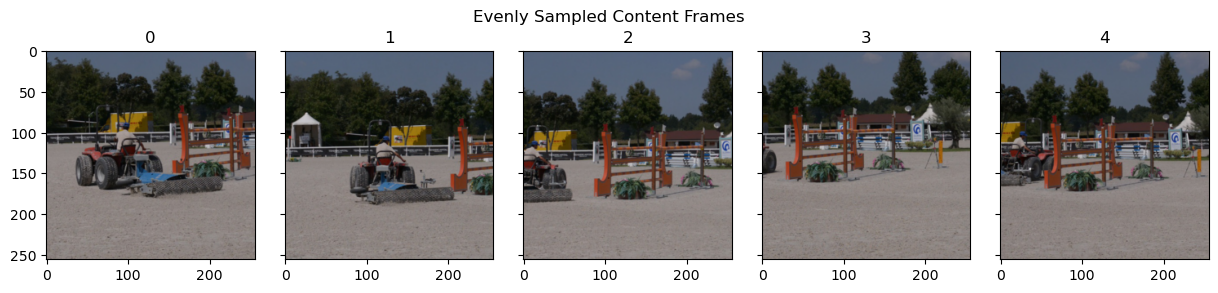

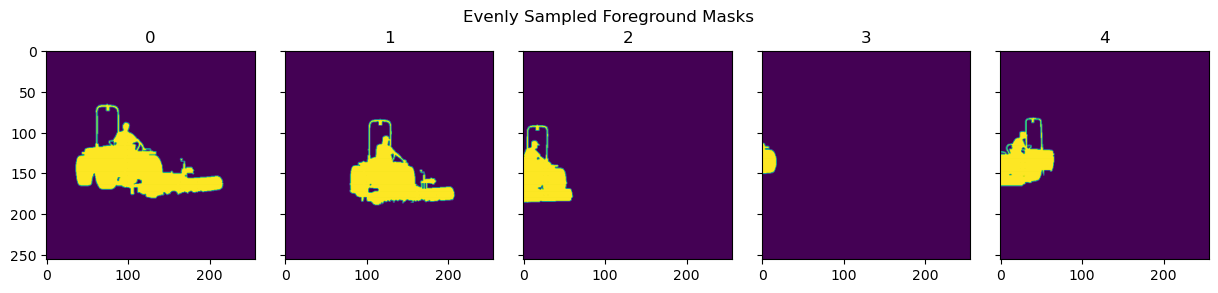

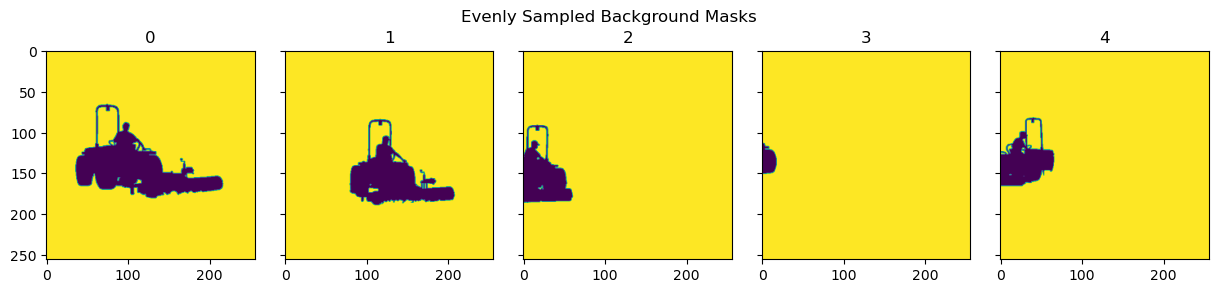

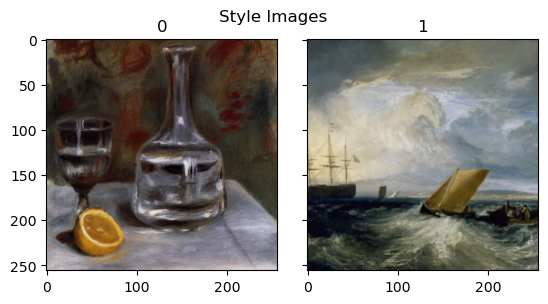

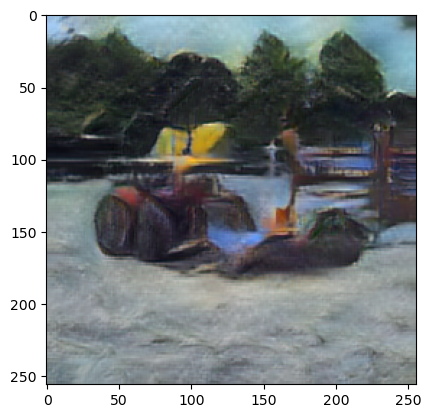

out min max :  tensor(-1.6428, device='cuda:0') tensor(3.6669, device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')


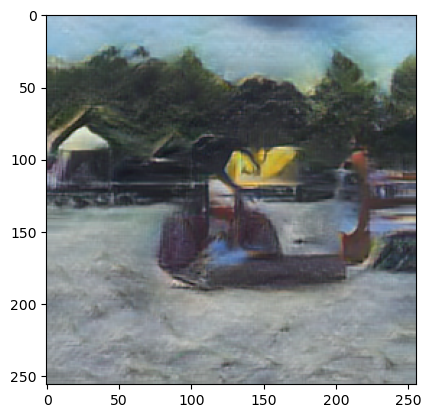

out min max :  tensor(-1.9254, device='cuda:0') tensor(3.8411, device='cuda:0') tensor(0., device='cuda:0') tensor(1.0000, device='cuda:0')


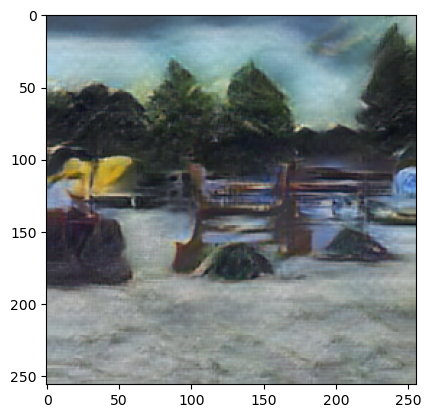

out min max :  tensor(-1.6607, device='cuda:0') tensor(3.5515, device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')


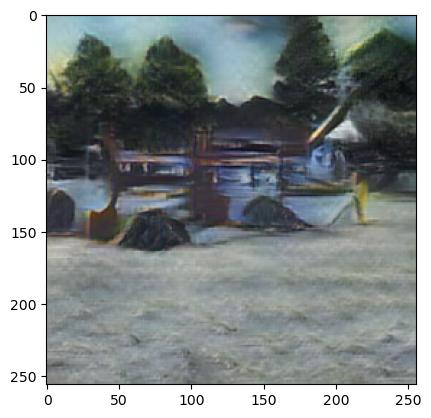

out min max :  tensor(-1.5836, device='cuda:0') tensor(3.7476, device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')


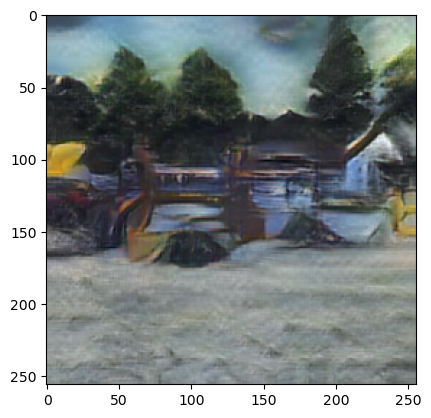

out min max :  tensor(-1.9548, device='cuda:0') tensor(4.1728, device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')


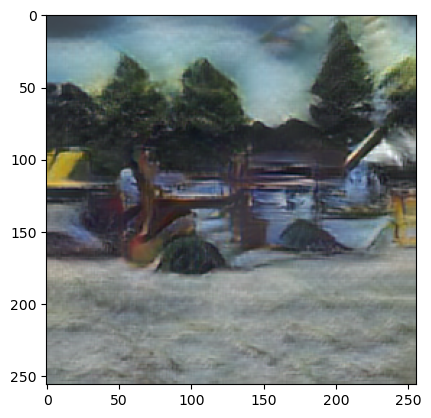

out min max :  tensor(-1.9251, device='cuda:0') tensor(3.4955, device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')


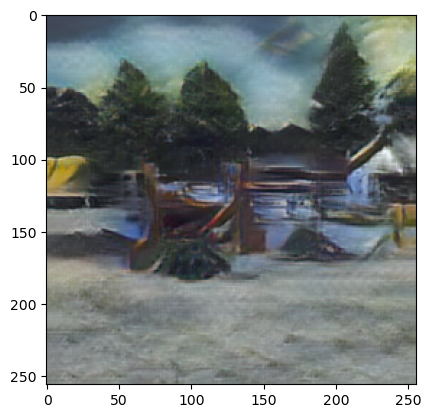

out min max :  tensor(-1.7049, device='cuda:0') tensor(3.6421, device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')


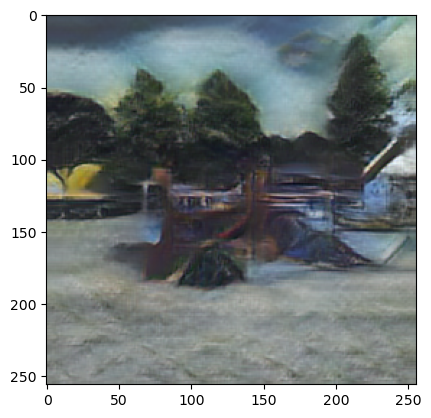

out min max :  tensor(-1.9001, device='cuda:0') tensor(3.5480, device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')


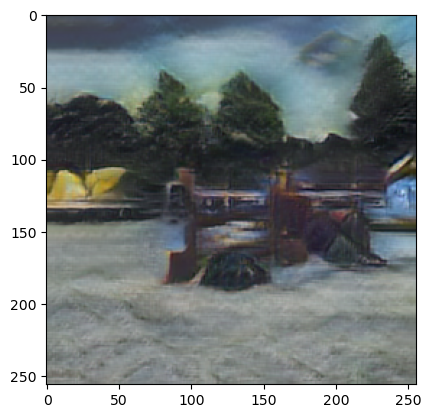

out min max :  tensor(-1.8063, device='cuda:0') tensor(3.1840, device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')


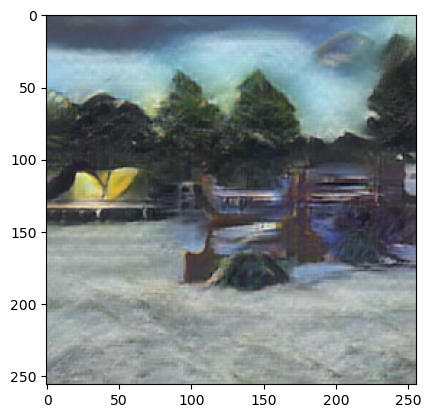

out min max :  tensor(-1.5524, device='cuda:0') tensor(3.5296, device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')
torch.Size([40, 3, 256, 256])
denormalized out min max :  0 255


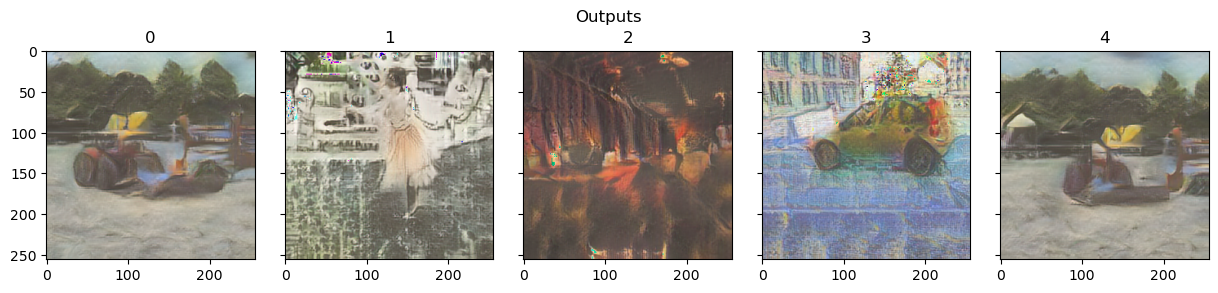

In [24]:
from torchvision.utils import save_image,make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# infer_vgg_feature_extractor = get_VGG_feature_extractor().to(device)
infer_vgg_feature_extractor = get_vgg_normalized().to(device)


infer_decoder = get_decoder().to(device)
if os.path.exists(checkpoints_root + '/decoder.pth'):
    checkpoint = torch.load(checkpoints_root + '/decoder.pth')
    infer_decoder.load_state_dict(checkpoint)
    print('loaded decoder')

infer_model = MaskedVideoStyleTransfer(infer_vgg_feature_extractor, infer_decoder).to(device)
pre_model_name = '/ckpt_encdec_baseline_0_3.pth'
if os.path.exists(checkpoints_root + pre_model_name):
    checkpoint = torch.load(checkpoints_root + pre_model_name)
    infer_model.load_state_dict(checkpoint)
    print(f'loaded model {pre_model_name}')
#freeze param weights of required modules
for child in infer_model.named_children():
    print(child[0])
    if child[0] in ['vgg_feature_extractor', 'decoder']:
        child[1].requires_grad_(False)

infer_model.eval()

count = 0
random_idx = np.random.randint(5)
for i ,(cont_imgs, mask_img_lists, style_img_lists) in enumerate(val_loader):
    if i < random_idx:
        continue
    #cont_img is B x num_frames x 3 x 256 x 256
    bs = cont_imgs.shape[0]
    plot_video(rows=1, cols=5, frame_list=denormalize(cont_imgs[0]), plot_width=15., plot_height=3.,
               title='Evenly Sampled Content Frames')
    plot_video(rows=1, cols=5, frame_list=(mask_img_lists[0][0] * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
               title='Evenly Sampled Foreground Masks')
    plot_video(rows=1, cols=5, frame_list=(mask_img_lists[0][1] * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
               title='Evenly Sampled Background Masks')
    plot_video(rows=1, cols=2, frame_list=denormalize(style_img_lists[0]), plot_width=15., plot_height=3.,
               title='Style Images')

    cpe_1_all = torch.randn(size=(bs, 64, 256, 256), dtype=torch.float32).to(device)
    cpe_2_all = torch.randn(size=(bs, 128, 128, 128), dtype=torch.float32).to(device)
    cpe_3_all = torch.randn(size=(bs, 256, 64, 64), dtype=torch.float32).to(device)
    cpe_4_all = torch.randn(size=(bs, 512, 32, 32), dtype=torch.float32).to(device)
    adap_1_all = torch.randn(size=(bs, 8, 128, 128), dtype=torch.float32).to(device)
    adap_2_all = torch.randn(size=(bs, 16, 64, 64), dtype=torch.float32).to(device)
    adap_3_all = torch.randn(size=(bs, 32, 32, 32), dtype=torch.float32).to(device)
    output_prev = torch.randn(size=(bs, 3, 256, 256), dtype=torch.float32).to(device)
    mask_img_list_prev = torch.randn(size=(bs, num_classes, 1, 256, 256), dtype=torch.float32).to(device)

    output_frames = []
    for frame_idx in range(cont_imgs.shape[1]):
        cont_img = cont_imgs[:,frame_idx,:,:,:].to(device)
        mask_img_list = mask_img_lists[:,:,frame_idx,:,:,:].to(device)
        style_img_list = style_img_lists.to(device)
        # print('training: ', i, cont_img.shape, (mask_img_list.shape), (style_img_list.shape))

        all_cont_feats = infer_vgg_feature_extractor(cont_img)
        cont_feat = all_cont_feats['layer4']
        all_style_feats_list = [infer_vgg_feature_extractor(style_img_list[:,i,:,:,:]) for i in range(num_classes)]
        style_feat_list = [all_style_feats_list[i]['layer4'] for i in range(num_classes)]

        if frame_idx == 0:
            cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all = all_cont_feats['layer1'], all_cont_feats['layer2'], all_cont_feats['layer3'], all_cont_feats['layer4']
            mask_img_list_prev = mask_img_list
        output, bilateral_grid, cpe_1_all_, cpe_2_all_, cpe_3_all_, cpe_4_all_, adap_1_all_, adap_2_all_, adap_3_all_ = infer_model(cont_img, mask_img_list, style_img_list, mask_img_list_prev, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all)

        output_prev = output.clone().detach()
        mask_img_list_prev = mask_img_list.clone().detach()

        grid_out = make_grid(output[0], nrow=1, normalize = True)

        plt.imshow(grid_out.cpu().detach().permute(1,2,0).numpy())
        plt.show()
        print('out min max : ', output.min(), output.max(), grid_out.min(), grid_out.max())
        output_frames.append(output)

    output_frames_tensor = torch.cat(output_frames, dim=0).to(device)
    print(output_frames_tensor.shape)
    denormalized_output = denormalize(output_frames_tensor.cpu())
    print('denormalized out min max : ', np.min(denormalized_output), np.max(denormalized_output))
    plot_video(rows=1, cols=5, frame_list=denormalized_output, plot_width=15., plot_height=3.,
               title='Outputs')
    count += 1
    if count > 0:
        break


torch.Size([4, 2, 1, 256, 256])
torch.Size([256, 256])
tensor(0., device='cuda:0') tensor(1.0000, device='cuda:0')


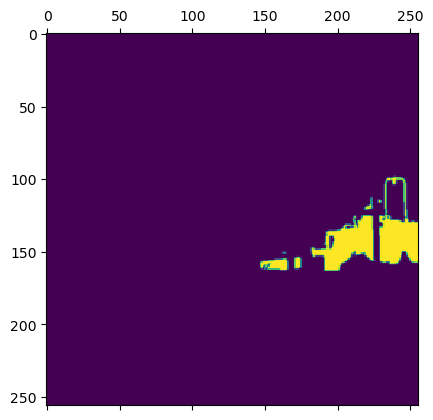

torch.Size([32, 32])
tensor(530.6586, device='cuda:0') tensor(2915.4282, device='cuda:0')



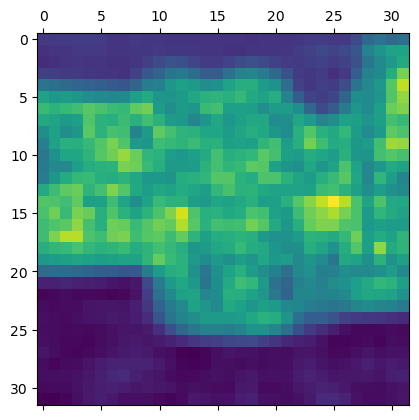

In [25]:
print(mask_img_list.shape)
temp = torch.squeeze(mask_img_list[0])[0]
print(temp.shape)
print(temp.min(), temp.max())
plt.matshow(temp.detach().cpu().numpy())
plt.show()

temp = torch.sum(torch.squeeze(bilateral_grid[0]), dim=0)
print(temp.shape)
print(temp.min(), temp.max())
print()
plt.matshow(temp.detach().cpu().numpy())
plt.show()


In [ ]:
# !wget https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time/download?datasetVersionNumber=1

# Inference

In [ ]:
from torchvision.utils import save_image,make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# infer_vgg_feature_extractor = get_VGG_feature_extractor().to(device)
infer_vgg_feature_extractor = get_vgg_normalized().to(device)


infer_decoder = get_decoder().to(device)
if os.path.exists(checkpoints_root + '/decoder.pth'):
    checkpoint = torch.load(checkpoints_root + '/decoder.pth')
    infer_decoder.load_state_dict(checkpoint)
    print('loaded decoder')

infer_model = MaskedVideoStyleTransfer(infer_vgg_feature_extractor, infer_decoder).to(device)
pre_model_name = '/ckpt_encdec_19_79.pth'
if os.path.exists(checkpoints_root + pre_model_name):
    checkpoint = torch.load(checkpoints_root + pre_model_name)
    infer_model.load_state_dict(checkpoint)
    print('loaded model pre_model_name')

#freeze param weights of required modules
for child in infer_model.named_children():
    print(child[0])
    if child[0] in ['vgg_feature_extractor', 'decoder']:
        child[1].requires_grad_(False)

infer_model.eval()

count = 0
bs = 1
num_frames = 50


preprocess_cont = transforms.Compose([
    transforms.Resize(256),  # image batch, resize smaller edge to 299
    transforms.CenterCrop(256),  # image batch, center crop to square 299x299
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

preprocess_mask = transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),
    transforms.Resize(256),  # image batch, resize smaller edge to 299
    transforms.CenterCrop(256),  # image batch, center crop to square 299x299
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

preprocess_style = transforms.Compose([
    transforms.Resize(256),  # image batch, resize smaller edge to 299
    transforms.CenterCrop(256),  # image batch, center crop to square 299x299
    # transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

content_video_dir_list = [vid_root + '/bear']
mask_video_dir_list = [mask_root + '/bear']
style_pair_paths_list = [(style_root + '/all/William_Turner_28.jpg', style_root + '/all/Vincent_van_Gogh_95.jpg')]

# content_video_dir = vid_root + '/bear'
# mask_video_dir = mask_root + '/bear'
# style_f_path = style_root + '/all/William_Turner_28.jpg'
# style_b_path = style_root + '/all/Vincent_van_Gogh_95.jpg'

for content_video_dir, mask_video_dir in zip(content_video_dir_list, mask_video_dir_list):
    for style_pair_path in style_pair_paths_list:
        style_f_path, style_b_path = style_pair_path
        out_frames_path = sample_output_root + content_video_dir[content_video_dir.rindex('/'):] + '_' + style_f_path[style_f_path.rindex('/')+1:style_f_path.rindex('.')] + '_' + style_b_path[style_b_path.rindex('/')+1:style_b_path.rindex('.')]
        try:
            os.mkdir(out_frames_path)
        except OSError as error:
            print(error)
        # read and transform content frames
        # read and transform mask frames
        # read and transform style images

        cont_imgs_ = []
        mask_img_lists_ = []

        style_f = preprocess_style(torchvision.io.read_image(style_f_path).type(torch.float32)/255.0).unsqueeze(0)
        style_b = preprocess_style(torchvision.io.read_image(style_b_path).type(torch.float32)/255.0).unsqueeze(0)
        style_img_lists = torch.cat([style_f, style_b], dim = 0).unsqueeze(0)
        # print(style_img_lists.shape, style_img_lists.min(), style_img_lists.max())

        for i in range(num_frames):
            cont_frame = torchvision.io.read_image(content_video_dir + f'/{i:05d}.jpg').type(torch.float32)/255.0
            mask_frame = torchvision.io.read_image(mask_video_dir + f'/{i:05d}.png').type(torch.float32)/255.0

            #transform
            cont_frame = cont_frame.unsqueeze(0)
            mask_frame_f = mask_frame.unsqueeze(0)
            mask_frame_b = (1.0 - mask_frame).unsqueeze(0)
            mask_frame = torch.cat([mask_frame_f, mask_frame_b], dim=0).to(device)

            cont_imgs_.append(cont_frame)
            mask_img_lists_.append(preprocess_mask(mask_frame).unsqueeze(1))

        cont_imgs = preprocess_cont(torch.cat(cont_imgs_, dim=0).to(device)).unsqueeze(0)
        mask_img_lists = torch.cat(mask_img_lists_, dim=1).to(device).unsqueeze(0)

        # print(cont_imgs.shape, cont_imgs.min(), cont_imgs.max())
        # print(mask_img_lists.shape, mask_img_lists.min(), mask_img_lists.max())

        cpe_1_all = torch.randn(size=(bs, 64, 256, 256), dtype=torch.float32).to(device)
        cpe_2_all = torch.randn(size=(bs, 128, 128, 128), dtype=torch.float32).to(device)
        cpe_3_all = torch.randn(size=(bs, 256, 64, 64), dtype=torch.float32).to(device)
        cpe_4_all = torch.randn(size=(bs, 512, 32, 32), dtype=torch.float32).to(device)
        adap_1_all = torch.randn(size=(bs, 8, 128, 128), dtype=torch.float32).to(device)
        adap_2_all = torch.randn(size=(bs, 16, 64, 64), dtype=torch.float32).to(device)
        adap_3_all = torch.randn(size=(bs, 32, 32, 32), dtype=torch.float32).to(device)
        output_prev = torch.randn(size=(bs, 3, 256, 256), dtype=torch.float32).to(device)
        mask_img_list_prev = torch.randn(size=(bs, num_classes, 1, 256, 256), dtype=torch.float32).to(device)

        output_frames = []
        for frame_idx in range(cont_imgs.shape[1]):
            cont_img = cont_imgs[:,frame_idx,:,:,:].to(device)
            mask_img_list = mask_img_lists[:,:,frame_idx,:,:,:].to(device)
            style_img_list = style_img_lists.to(device)
            
            all_cont_feats = infer_vgg_feature_extractor(cont_img)
            cont_feat = all_cont_feats['layer4']
            all_style_feats_list = [infer_vgg_feature_extractor(style_img_list[:,i,:,:,:]) for i in range(num_classes)]
            style_feat_list = [all_style_feats_list[i]['layer4'] for i in range(num_classes)]

            if frame_idx == 0:
                cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all = all_cont_feats['layer1'], all_cont_feats['layer2'], all_cont_feats['layer3'], all_cont_feats['layer4']
                mask_img_list_prev = mask_img_list
            output, bilateral_grid, cpe_1_all_, cpe_2_all_, cpe_3_all_, cpe_4_all_, adap_1_all_, adap_2_all_, adap_3_all_ = infer_model(cont_img, mask_img_list, style_img_list, mask_img_list_prev, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all)

            output_prev = output.clone().detach()
            mask_img_list_prev = mask_img_list.clone().detach()

            grid_out = make_grid(output, nrow=1, normalize = True)
            #save grid_out to sample_output/bear/frame_count.jpg
            # plt.imshow(grid_out.cpu().detach().permute(1,2,0).numpy())
            # plt.show()
            # print('out min max : ', output.shape, output.min(), output.max(), grid_out.shape, grid_out.min(), grid_out.max())
            output_frames.append(output)
            # break

        output_frames_tensor = torch.cat(output_frames, dim=0).to(device)
        for i in range(output_frames_tensor.shape[0]):
            save_image(make_grid(output_frames_tensor[i], nrow=1, normalize = True), out_frames_path + f'/{i:05d}.jpg')

#create video using out_frames

In [ ]:
!pip install ffmpeg

In [ ]:
!ffmpeg -framerate 10  -i /home/hp2427/mvst/data/videos/bear/%05d.jpg  -c:v libx264 -r 30 /home/hp2427/mvst/sample_output/bear_original.mp4
!ffmpeg -framerate 10  -i /home/hp2427/mvst/sample_output/bear/%05d.jpg  -c:v libx264 -r 30 /home/hp2427/mvst/sample_output/bear_stylized.mp4